In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg

# Raw test data
data = {
    'tps': [
        1000, 100, 100,
        200, 200, 250,
        250, 320, 430,
        500, 500, 496,
        498, 50, 50,
        700, 900
    ],
    'k8s_nodes_cpu': [
        34.5, 5, 4.6, 7.8, 8.1, 9.3, 9.9, 11.9, 15.7, 21.0,
        23.0, 22.1, 21.1, 2.8, 2.7, 27.2, 32
    ],
    'pods_cpu': [
        33.9, 3.7, 3.9, 6.9, 7.3, 8.4, 8.9, 10.9, 14.5, 19.3,
        19.2, 18.6, 19.3, 2.3, 2.1, 25.2, 33.5
    ]
}

df = pd.DataFrame(data)
print("Performance Test Data:")
print(df.to_string(index=False))
print(f"\nTotal number of tests: {len(df)}")

Performance Test Data:
 tps  k8s_nodes_cpu  pods_cpu
1000           34.5      33.9
 100            5.0       3.7
 100            4.6       3.9
 200            7.8       6.9
 200            8.1       7.3
 250            9.3       8.4
 250            9.9       8.9
 320           11.9      10.9
 430           15.7      14.5
 500           21.0      19.3
 500           23.0      19.2
 496           22.1      18.6
 498           21.1      19.3
  50            2.8       2.3
  50            2.7       2.1
 700           27.2      25.2
 900           32.0      33.5

Total number of tests: 17


In [2]:
# Calculate per-transaction CPU usage in milliseconds
df['per_txn_cpu_ms'] = (df['pods_cpu'] * 1000) / df['tps']

print("Per-Transaction CPU Usage:")
print(df[['tps', 'pods_cpu', 'per_txn_cpu_ms']].to_string(index=False))
print(f"\nMean per-txn CPU: {df['per_txn_cpu_ms'].mean():.2f} ms")
print(f"Std dev: {df['per_txn_cpu_ms'].std():.2f} ms")

Per-Transaction CPU Usage:
       tps  pods_cpu  per_txn_cpu_ms
986.492333      33.9       34.364180
 98.650549       3.7       37.506127
 98.358242       3.9       39.650973
192.180541       6.9       35.903739
192.954595       7.3       37.832735
241.468888       8.4       34.787090
240.335158       8.9       37.031619
317.931111      10.9       34.284157
430.227429      14.5       33.703105
500.142246      19.3       38.589022
499.608250      19.2       38.430110
495.819479      18.6       37.513653
497.678212      19.3       38.780078
 49.643956       2.3       46.329910
 48.973481       2.1       42.880350
694.733389      25.2       36.272908
894.197765      31.5       35.227107

Mean per-txn CPU: 37.59 ms
Std dev: 3.23 ms


In [14]:
# Linear regression using SVD: per_txn_cpu_ms vs tps
# Model: per_txn_cpu_ms = intercept + slope * tps

X = df['tps'].values
y = df['per_txn_cpu_ms'].values

# Add column of ones for intercept
A = np.column_stack([np.ones(len(X)), X])

# Solve using SVD: A * beta = y
U, s, Vt = linalg.svd(A, full_matrices=False)
beta = Vt.T @ np.diag(1/s) @ U.T @ y

intercept_1 = beta[0]
slope_1 = beta[1]


# Predictions
y_pred = intercept_1 + slope_1 * X

# Calculate R-squared
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_1 = 1 - (ss_res / ss_tot)

# Calculate RMSE
rmse_1 = np.sqrt(np.mean((y - y_pred)**2))

print("=" * 70)
print("LINEAR REGRESSION RESULTS (using SVD)")
print("=" * 70)
print("\nModel: Per-Transaction CPU (ms) = Intercept + Slope × TPS")
print(f"\nIntercept: {intercept_1:.6f} ms")
print(f"Slope:     {slope_1:.8f} ms/tps")
print(f"\nR²:        {r_squared_1:.6f}")
print(f"RMSE:      {rmse_1:.4f} ms")
print("\nInterpretation:")
print(f"  - Base CPU overhead: {intercept_1:.2f} ms per transaction")
print(f"  - Each additional TPS {'increases' if slope_1 > 0 else 'decreases'} per-txn CPU by {abs(slope_1)*100:.4f} ms per 100 TPS")

LINEAR REGRESSION RESULTS (using SVD)

Model: Per-Transaction CPU (ms) = Intercept + Slope × TPS

Intercept: 39.881193 ms
Slope:     -0.00600263 ms/tps

R²:        0.276814
RMSE:      2.6621 ms

Interpretation:
  - Base CPU overhead: 39.88 ms per transaction
  - Each additional TPS decreases per-txn CPU by 0.6003 ms per 100 TPS


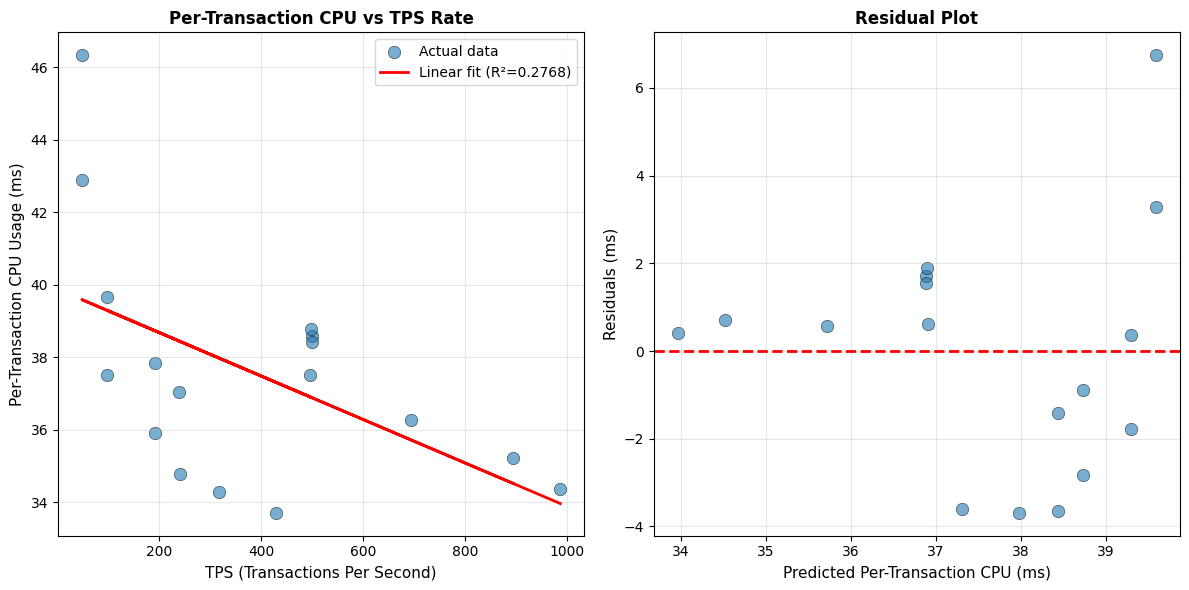

Equation: Per-Txn-CPU = 39.8812 + -0.00600263 × TPS


In [4]:
# Visualize regression 1
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X, y, alpha=0.6, s=80, edgecolors='k', linewidths=0.5, label='Actual data')
plt.plot(X, y_pred, 'r-', linewidth=2, label=f'Linear fit (R²={r_squared_1:.4f})')
plt.xlabel('TPS (Transactions Per Second)', fontsize=11)
plt.ylabel('Per-Transaction CPU Usage (ms)', fontsize=11)
plt.title('Per-Transaction CPU vs TPS Rate', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Residuals plot
plt.subplot(1, 2, 2)
residuals = y - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, s=80, edgecolors='k', linewidths=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Per-Transaction CPU (ms)', fontsize=11)
plt.ylabel('Residuals (ms)', fontsize=11)
plt.title('Residual Plot', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Equation: Per-Txn-CPU = {intercept_1:.4f} + {slope_1:.8f} × TPS")

In [15]:
# Calculate per-transaction CPU including K8s overhead
df['per_txn_cpu_ms_including_k8s'] = (df['k8s_nodes_cpu'] * 1000) / df['tps']

print("\n" + "="*70)
print("PER-TRANSACTION CPU INCLUDING K8s OVERHEAD")
print("="*70)
print("\nper_txn_cpu_ms_including_k8s = (K8s nodes CPU * 1000) / TPS")
print("\nSample data:")
print(df[['tps', 'k8s_nodes_cpu', 'per_txn_cpu_ms_including_k8s']].head(10))



PER-TRANSACTION CPU INCLUDING K8s OVERHEAD

per_txn_cpu_ms_including_k8s = (K8s nodes CPU * 1000) / TPS

Sample data:
          tps  k8s_nodes_cpu  per_txn_cpu_ms_including_k8s
0  986.492333           36.5                     36.999781
1   98.650549            4.4                     44.601880
2   98.358242            4.6                     46.767814
3  192.180541            7.8                     40.586836
4  192.954595            8.1                     41.978788
5  241.468888            9.3                     38.514279
6  240.335158            9.9                     41.192475
7  317.931111           11.9                     37.429492
8  430.227429           15.7                     36.492327
9  500.142246           21.0                     41.988055


In [16]:
# Linear regression using SVD: per_txn_cpu_ms_including_k8s vs tps
# Model: per_txn_cpu_ms_including_k8s = intercept + slope * tps

X_k8s = df['tps'].values
y_k8s = df['per_txn_cpu_ms_including_k8s'].values

# Add column of ones for intercept
A_k8s = np.column_stack([np.ones(len(X_k8s)), X_k8s])

# Solve using SVD: A * beta = y
U_k8s, s_k8s, Vt_k8s = linalg.svd(A_k8s, full_matrices=False)
beta_k8s = Vt_k8s.T @ np.diag(1/s_k8s) @ U_k8s.T @ y_k8s

intercept_k8s = beta_k8s[0]
slope_k8s = beta_k8s[1]

# Predictions
y_k8s_pred = intercept_k8s + slope_k8s * X_k8s

# Calculate R-squared
ss_res_k8s = np.sum((y_k8s - y_k8s_pred)**2)
ss_tot_k8s = np.sum((y_k8s - np.mean(y_k8s))**2)
r_squared_k8s = 1 - (ss_res_k8s / ss_tot_k8s)

# Calculate RMSE
rmse_k8s = np.sqrt(np.mean((y_k8s - y_k8s_pred)**2))

print("=" * 70)
print("LINEAR REGRESSION RESULTS - INCLUDING K8s OVERHEAD (using SVD)")
print("=" * 70)
print("\nModel: Per-Transaction CPU Including K8s (ms) = Intercept + Slope × TPS")
print(f"\nIntercept: {intercept_k8s:.6f} ms")
print(f"Slope:     {slope_k8s:.8f} ms/tps")
print(f"\nR²:        {r_squared_k8s:.6f}")
print(f"RMSE:      {rmse_k8s:.4f} ms")
print("\nInterpretation:")
print(f"  - Base CPU overhead (total K8s): {intercept_k8s:.2f} ms per transaction")
print(f"  - Each additional TPS {'increases' if slope_k8s > 0 else 'decreases'} per-txn CPU by {abs(slope_k8s)*100:.4f} ms per 100 TPS")


LINEAR REGRESSION RESULTS - INCLUDING K8s OVERHEAD (using SVD)

Model: Per-Transaction CPU Including K8s (ms) = Intercept + Slope × TPS

Intercept: 47.263597 ms
Slope:     -0.01286607 ms/tps

R²:        0.403293
RMSE:      4.2940 ms

Interpretation:
  - Base CPU overhead (total K8s): 47.26 ms per transaction
  - Each additional TPS decreases per-txn CPU by 1.2866 ms per 100 TPS


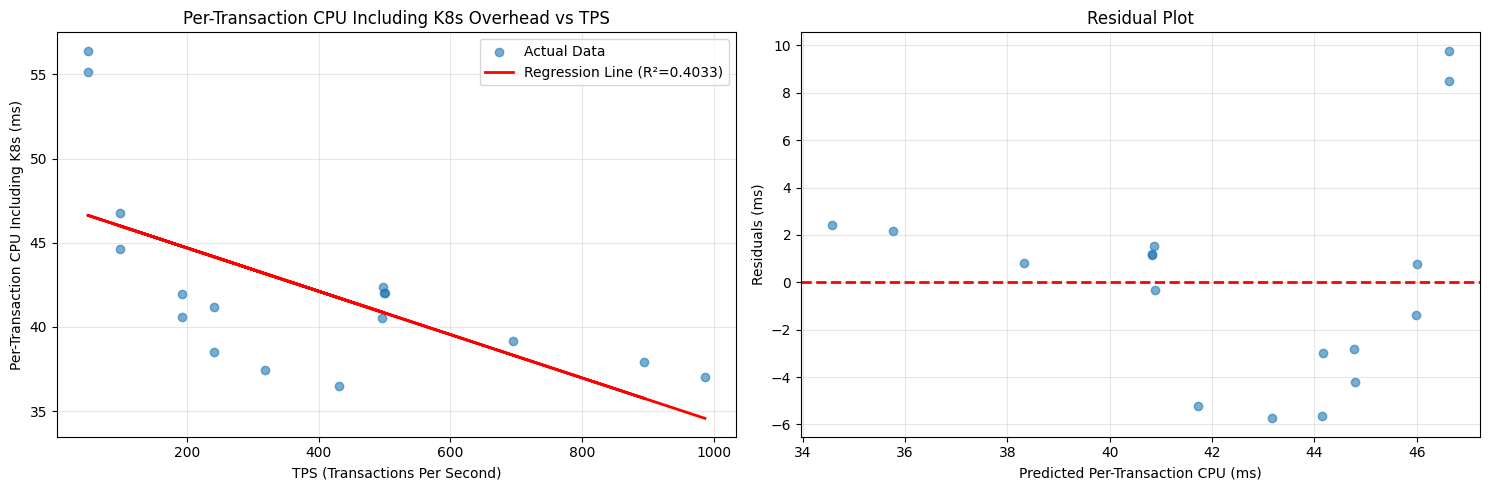

In [17]:
# Visualize regression: per_txn_cpu_ms_including_k8s vs TPS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot with regression line
ax1.scatter(X_k8s, y_k8s, alpha=0.6, label='Actual Data')
ax1.plot(X_k8s, y_k8s_pred, 'r-', linewidth=2, label=f'Regression Line (R²={r_squared_k8s:.4f})')
ax1.set_xlabel('TPS (Transactions Per Second)')
ax1.set_ylabel('Per-Transaction CPU Including K8s (ms)')
ax1.set_title('Per-Transaction CPU Including K8s Overhead vs TPS')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residual plot
residuals_k8s = y_k8s - y_k8s_pred
ax2.scatter(y_k8s_pred, residuals_k8s, alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted Per-Transaction CPU (ms)')
ax2.set_ylabel('Residuals (ms)')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# Calculate fixed usage cores (infrastructure overhead)
df['fixed_usage_cores'] = df['k8s_nodes_cpu'] - df['pods_cpu']

print("Fixed Usage Cores (Infrastructure Overhead):")
print(df[['tps', 'k8s_nodes_cpu', 'pods_cpu', 'fixed_usage_cores']].to_string(index=False))
print(f"\nMean fixed usage: {df['fixed_usage_cores'].mean():.2f} cores")
print(f"Std dev: {df['fixed_usage_cores'].std():.2f} cores")

Fixed Usage Cores (Infrastructure Overhead):
       tps  k8s_nodes_cpu  pods_cpu  fixed_usage_cores
986.492333           36.5      33.9                2.6
 98.650549            4.4       3.7                0.7
 98.358242            4.6       3.9                0.7
192.180541            7.8       6.9                0.9
192.954595            8.1       7.3                0.8
241.468888            9.3       8.4                0.9
240.335158            9.9       8.9                1.0
317.931111           11.9      10.9                1.0
430.227429           15.7      14.5                1.2
500.142246           21.0      19.3                1.7
499.608250           21.0      19.2                1.8
495.819479           20.1      18.6                1.5
497.678212           21.1      19.3                1.8
 49.643956            2.8       2.3                0.5
 48.973481            2.7       2.1                0.6
694.733389           27.2      25.2                2.0
894.197765          

In [7]:
# Linear regression using SVD: fixed_usage_cores vs tps
# Model: fixed_usage_cores = intercept + slope * tps

X2 = df['tps'].values
y2 = df['fixed_usage_cores'].values

# Add column of ones for intercept
A2 = np.column_stack([np.ones(len(X2)), X2])

# Solve using SVD: A * beta = y
U2, s2, Vt2 = linalg.svd(A2, full_matrices=False)
beta2 = Vt2.T @ np.diag(1/s2) @ U2.T @ y2

intercept_2 = beta2[0]
slope_2 = beta2[1]

# Predictions
y2_pred = intercept_2 + slope_2 * X2

# Calculate R-squared
ss_res_2 = np.sum((y2 - y2_pred)**2)
ss_tot_2 = np.sum((y2 - np.mean(y2))**2)
r_squared_2 = 1 - (ss_res_2 / ss_tot_2)

# Calculate RMSE
rmse_2 = np.sqrt(np.mean((y2 - y2_pred)**2))

print("=" * 70)
print("LINEAR REGRESSION RESULTS (using SVD)")
print("=" * 70)
print("\nModel: Fixed Usage Cores = Intercept + Slope × TPS")
print(f"\nIntercept: {intercept_2:.6f} cores")
print(f"Slope:     {slope_2:.8f} cores/tps")
print(f"\nR²:        {r_squared_2:.6f}")
print(f"RMSE:      {rmse_2:.4f} cores")
print("\nInterpretation:")
print(f"  - Base infrastructure overhead: {intercept_2:.2f} cores")
print(f"  - Each additional TPS {'increases' if slope_2 > 0 else 'decreases'} overhead by {abs(slope_2)*1000:.4f} cores per 1000 TPS")

LINEAR REGRESSION RESULTS (using SVD)

Model: Fixed Usage Cores = Intercept + Slope × TPS

Intercept: 0.443014 cores
Slope:     0.00224848 cores/tps

R²:        0.965701
RMSE:      0.1163 cores

Interpretation:
  - Base infrastructure overhead: 0.44 cores
  - Each additional TPS increases overhead by 2.2485 cores per 1000 TPS


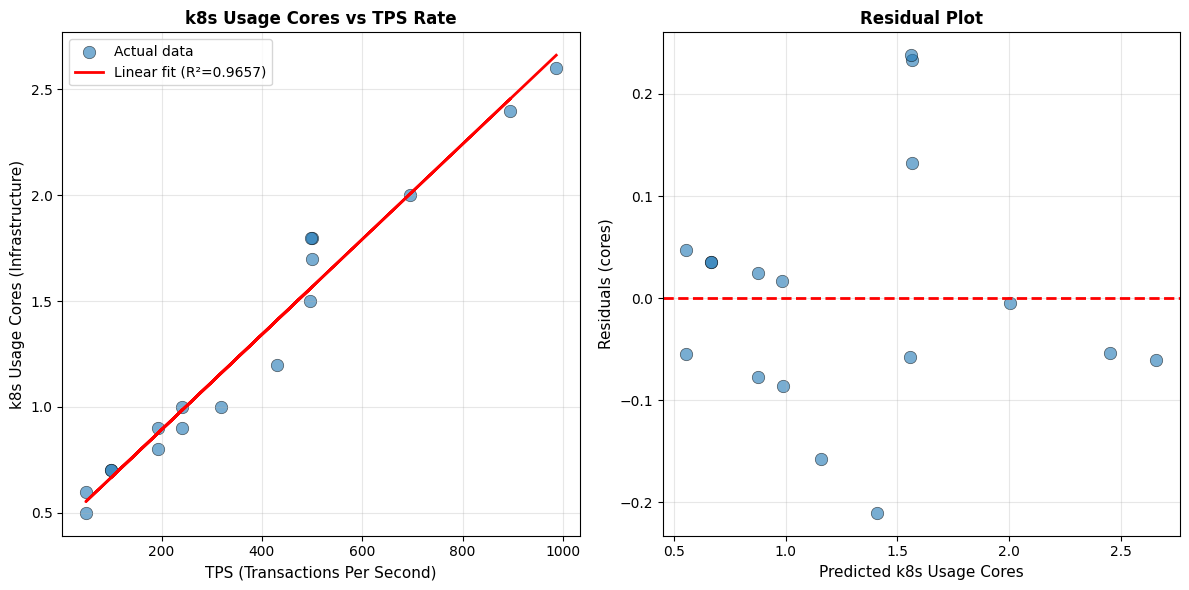

Equation: k8s-Usage-Cores = 0.4430 + 0.00224848 × TPS


In [22]:
# Visualize regression 2
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X2, y2, alpha=0.6, s=80, edgecolors='k', linewidths=0.5, label='Actual data')
plt.plot(X2, y2_pred, 'r-', linewidth=2, label=f'Linear fit (R²={r_squared_2:.4f})')
plt.xlabel('TPS (Transactions Per Second)', fontsize=11)
plt.ylabel('k8s Usage Cores (Infrastructure)', fontsize=11)
plt.title('k8s Usage Cores vs TPS Rate', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Residuals plot
plt.subplot(1, 2, 2)
residuals_2 = y2 - y2_pred
plt.scatter(y2_pred, residuals_2, alpha=0.6, s=80, edgecolors='k', linewidths=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted k8s Usage Cores', fontsize=11)
plt.ylabel('Residuals (cores)', fontsize=11)
plt.title('Residual Plot', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Equation: k8s-Usage-Cores = {intercept_2:.4f} + {slope_2:.8f} × TPS")

In [10]:
# Analysis 3: Total K8s CPU Usage vs TPS
print("\n" + "="*60)
print("Analysis 3: Total K8s CPU Usage vs TPS")
print("="*60)

# Prepare data
X3 = df[['tps']].values
y3 = df['k8s_nodes_cpu'].values

# Add intercept column
A3 = np.column_stack([np.ones(len(X3)), X3])

# SVD-based linear regression
U3, s3, Vt3 = np.linalg.svd(A3, full_matrices=False)
beta3 = Vt3.T @ np.linalg.inv(np.diag(s3)) @ U3.T @ y3

intercept_3 = beta3[0]
slope_3 = beta3[1]

# Predictions
y3_pred = A3 @ beta3

# Calculate metrics
residuals_3 = y3 - y3_pred
ss_res_3 = np.sum(residuals_3**2)
ss_tot_3 = np.sum((y3 - np.mean(y3))**2)
r_squared_3 = 1 - (ss_res_3 / ss_tot_3)
rmse_3 = np.sqrt(np.mean(residuals_3**2))

print(f"\nLinear Regression Results (using SVD):")
print(f"Equation: K8s CPU = {intercept_3:.4f} + {slope_3:.6f} * TPS")
print(f"Intercept (base CPU cores): {intercept_3:.4f}")
print(f"Slope (cores per TPS): {slope_3:.6f}")
print(f"R² Score: {r_squared_3:.4f}")
print(f"RMSE: {rmse_3:.4f}")



Analysis 3: Total K8s CPU Usage vs TPS

Linear Regression Results (using SVD):
Equation: K8s CPU = 0.9627 + 0.037293 * TPS
Intercept (base CPU cores): 0.9627
Slope (cores per TPS): 0.037293
R² Score: 0.9934
RMSE: 0.8340


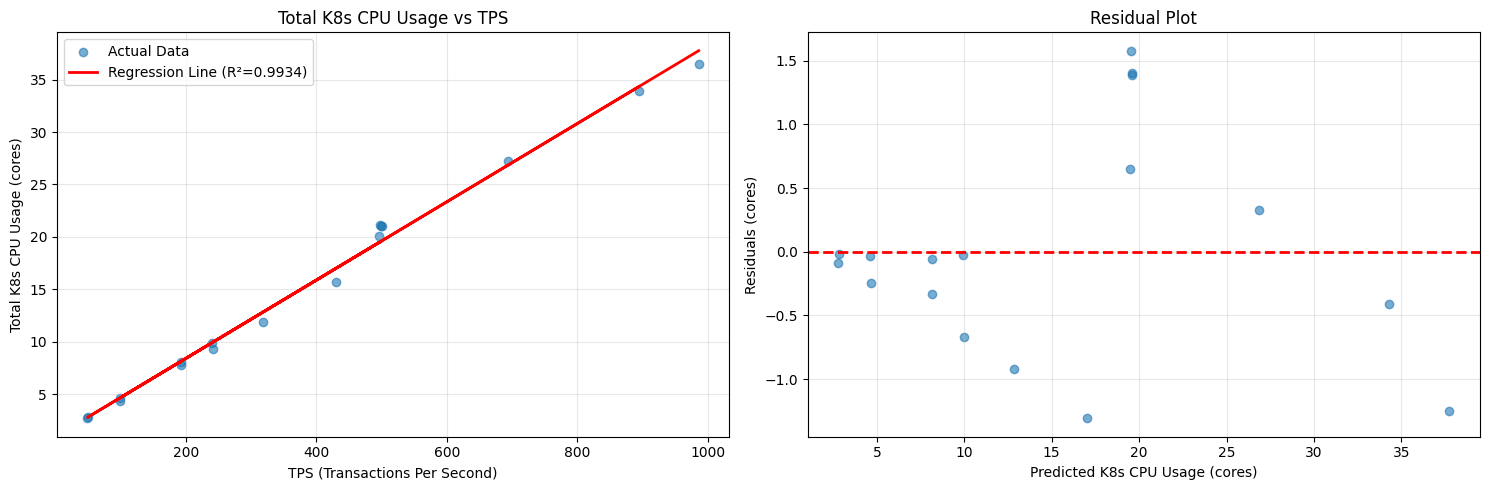


Interpretation:
- Base CPU usage: 0.9627 cores (overhead when TPS = 0)
- Per TPS CPU cost: 0.037293 cores per transaction/second
- At 1000 TPS: 38.26 cores total


In [11]:
# Visualize regression 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot with regression line
ax1.scatter(X3, y3, alpha=0.6, label='Actual Data')
ax1.plot(X3, y3_pred, 'r-', linewidth=2, label=f'Regression Line (R²={r_squared_3:.4f})')
ax1.set_xlabel('TPS (Transactions Per Second)')
ax1.set_ylabel('Total K8s CPU Usage (cores)')
ax1.set_title('Total K8s CPU Usage vs TPS')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residual plot
ax2.scatter(y3_pred, residuals_3, alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted K8s CPU Usage (cores)')
ax2.set_ylabel('Residuals (cores)')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"- Base CPU usage: {intercept_3:.4f} cores (overhead when TPS = 0)")
print(f"- Per TPS CPU cost: {slope_3:.6f} cores per transaction/second")
print(f"- At 1000 TPS: {intercept_3 + slope_3*1000:.2f} cores total")


In [12]:
# Analysis 4: Pods CPU Usage vs TPS
print("\n" + "="*60)
print("Analysis 4: Pods CPU Usage vs TPS")
print("="*60)

# Prepare data
X4 = df[['tps']].values
y4 = df['pods_cpu'].values

# Add intercept column
A4 = np.column_stack([np.ones(len(X4)), X4])

# SVD-based linear regression
U4, s4, Vt4 = np.linalg.svd(A4, full_matrices=False)
beta4 = Vt4.T @ np.linalg.inv(np.diag(s4)) @ U4.T @ y4

intercept_4 = beta4[0]
slope_4 = beta4[1]

# Predictions
y4_pred = A4 @ beta4

# Calculate metrics
residuals_4 = y4 - y4_pred
ss_res_4 = np.sum(residuals_4**2)
ss_tot_4 = np.sum((y4 - np.mean(y4))**2)
r_squared_4 = 1 - (ss_res_4 / ss_tot_4)
rmse_4 = np.sqrt(np.mean(residuals_4**2))

print(f"\nLinear Regression Results (using SVD):")
print(f"Equation: Pods CPU = {intercept_4:.4f} + {slope_4:.6f} * TPS")
print(f"Intercept (base CPU cores): {intercept_4:.4f}")
print(f"Slope (cores per TPS): {slope_4:.6f}")
print(f"R² Score: {r_squared_4:.4f}")
print(f"RMSE: {rmse_4:.4f}")



Analysis 4: Pods CPU Usage vs TPS

Linear Regression Results (using SVD):
Equation: Pods CPU = 0.5197 + 0.035044 * TPS
Intercept (base CPU cores): 0.5197
Slope (cores per TPS): 0.035044
R² Score: 0.9942
RMSE: 0.7373


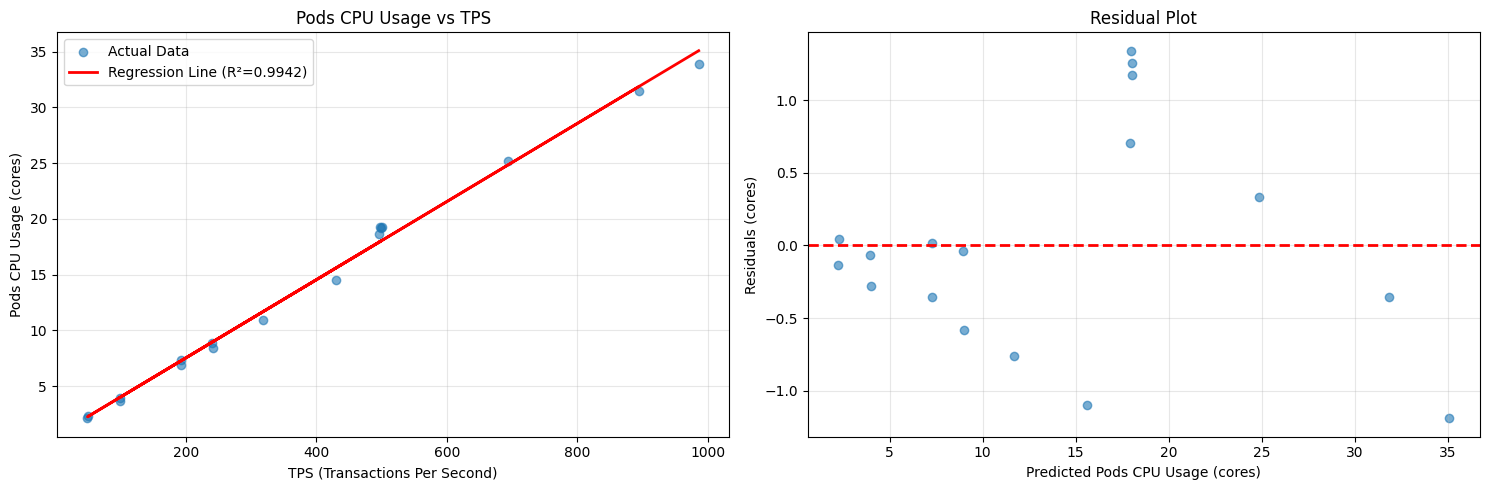


Interpretation:
- Base CPU usage: 0.5197 cores (overhead when TPS = 0)
- Per TPS CPU cost: 0.035044 cores per transaction/second
- At 1000 TPS: 35.56 cores total


In [13]:
# Visualize regression 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot with regression line
ax1.scatter(X4, y4, alpha=0.6, label='Actual Data')
ax1.plot(X4, y4_pred, 'r-', linewidth=2, label=f'Regression Line (R²={r_squared_4:.4f})')
ax1.set_xlabel('TPS (Transactions Per Second)')
ax1.set_ylabel('Pods CPU Usage (cores)')
ax1.set_title('Pods CPU Usage vs TPS')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residual plot
ax2.scatter(y4_pred, residuals_4, alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted Pods CPU Usage (cores)')
ax2.set_ylabel('Residuals (cores)')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"- Base CPU usage: {intercept_4:.4f} cores (overhead when TPS = 0)")
print(f"- Per TPS CPU cost: {slope_4:.6f} cores per transaction/second")
print(f"- At 1000 TPS: {intercept_4 + slope_4*1000:.2f} cores total")


In [18]:
# Analyze the R² values and investigate if the relationship is non-linear
print("\n" + "="*70)
print("ANALYSIS: Low R² Values - Investigating Non-Linear Relationships")
print("="*70)

# Looking at the per-transaction CPU data more closely
print(f"\nR² for per_txn_cpu_ms vs TPS: {r_squared_1:.4f}")
print(f"R² for per_txn_cpu_ms_including_k8s vs TPS: {r_squared_k8s:.4f}")

print("\nPossible reasons for low R²:")
print("1. The relationship may be hyperbolic (decreasing) rather than linear")
print("2. Per-transaction CPU typically DECREASES as TPS increases (efficiency at scale)")
print("3. There may be different performance regimes at different TPS ranges")
print("4. Outliers or noise in the measurements")

# Check the actual per-transaction values at different TPS ranges
print("\nPer-transaction CPU at different TPS levels:")
sorted_df = df.sort_values('tps')
print(sorted_df[['tps', 'per_txn_cpu_ms', 'per_txn_cpu_ms_including_k8s']].to_string(index=False))

# Look at the correlation
print(f"\nPearson correlation (per_txn_cpu_ms vs TPS): {np.corrcoef(df['tps'], df['per_txn_cpu_ms'])[0,1]:.4f}")
print(f"Pearson correlation (per_txn_cpu_ms_including_k8s vs TPS): {np.corrcoef(df['tps'], df['per_txn_cpu_ms_including_k8s'])[0,1]:.4f}")



ANALYSIS: Low R² Values - Investigating Non-Linear Relationships

R² for per_txn_cpu_ms vs TPS: 0.2768
R² for per_txn_cpu_ms_including_k8s vs TPS: 0.4033

Possible reasons for low R²:
1. The relationship may be hyperbolic (decreasing) rather than linear
2. Per-transaction CPU typically DECREASES as TPS increases (efficiency at scale)
3. There may be different performance regimes at different TPS ranges
4. Outliers or noise in the measurements

Per-transaction CPU at different TPS levels:
       tps  per_txn_cpu_ms  per_txn_cpu_ms_including_k8s
 48.973481       42.880350                     55.131879
 49.643956       46.329910                     56.401629
 98.358242       39.650973                     46.767814
 98.650549       37.506127                     44.601880
192.180541       35.903739                     40.586836
192.954595       37.832735                     41.978788
240.335158       37.031619                     41.192475
241.468888       34.787090                     38.

In [19]:
# Test different non-linear models: power law, exponential, and hyperbolic
print("\n" + "="*70)
print("TESTING NON-LINEAR MODELS")
print("="*70)

from scipy.optimize import curve_fit

# Model 1: Power law y = a * x^b
def power_law(x, a, b):
    return a * x**b

# Model 2: Exponential y = a * exp(b*x)
def exponential(x, a, b):
    return a * np.exp(b * x)

# Model 3: Hyperbolic y = a + b/x (decreasing, typical for per-transaction metrics)
def hyperbolic(x, a, b):
    return a + b / x

# Fit all three models for per_txn_cpu_ms
X_fit = df['tps'].values
y_fit = df['per_txn_cpu_ms'].values

try:
    # Power law fit
    params_power, _ = curve_fit(power_law, X_fit, y_fit, p0=[100, -0.5])
    y_power = power_law(X_fit, *params_power)
    r2_power = 1 - np.sum((y_fit - y_power)**2) / np.sum((y_fit - np.mean(y_fit))**2)
    print(f"\n1. POWER LAW: y = {params_power[0]:.4f} * x^{params_power[1]:.4f}")
    print(f"   R² = {r2_power:.4f}")
except:
    print("\n1. POWER LAW: Failed to fit")

try:
    # Exponential fit
    params_exp, _ = curve_fit(exponential, X_fit, y_fit, p0=[100, -0.001], maxfev=10000)
    y_exp = exponential(X_fit, *params_exp)
    r2_exp = 1 - np.sum((y_fit - y_exp)**2) / np.sum((y_fit - np.mean(y_fit))**2)
    print(f"\n2. EXPONENTIAL: y = {params_exp[0]:.4f} * exp({params_exp[1]:.6f} * x)")
    print(f"   R² = {r2_exp:.4f}")
except:
    print("\n2. EXPONENTIAL: Failed to fit")

try:
    # Hyperbolic fit
    params_hyp, _ = curve_fit(hyperbolic, X_fit, y_fit, p0=[30, 1000])
    y_hyp = hyperbolic(X_fit, *params_hyp)
    r2_hyp = 1 - np.sum((y_fit - y_hyp)**2) / np.sum((y_fit - np.mean(y_fit))**2)
    print(f"\n3. HYPERBOLIC: y = {params_hyp[0]:.4f} + {params_hyp[1]:.4f} / x")
    print(f"   R² = {r2_hyp:.4f}")
    print(f"   At high TPS, per-transaction CPU approaches: {params_hyp[0]:.4f} ms")
except Exception as e:
    print(f"\n3. HYPERBOLIC: Failed to fit - {e}")

print(f"\n4. LINEAR (baseline): y = {intercept_1:.4f} + {slope_1:.6f} * x")
print(f"   R² = {r_squared_1:.4f}")



TESTING NON-LINEAR MODELS

1. POWER LAW: y = 54.3394 * x^-0.0660
   R² = 0.5109

2. EXPONENTIAL: y = 40.0161 * exp(-0.000167 * x)
   R² = 0.2840

3. HYPERBOLIC: y = 35.1357 + 432.4022 / x
   R² = 0.6777
   At high TPS, per-transaction CPU approaches: 35.1357 ms

4. LINEAR (baseline): y = 39.8812 + -0.006003 * x
   R² = 0.2768


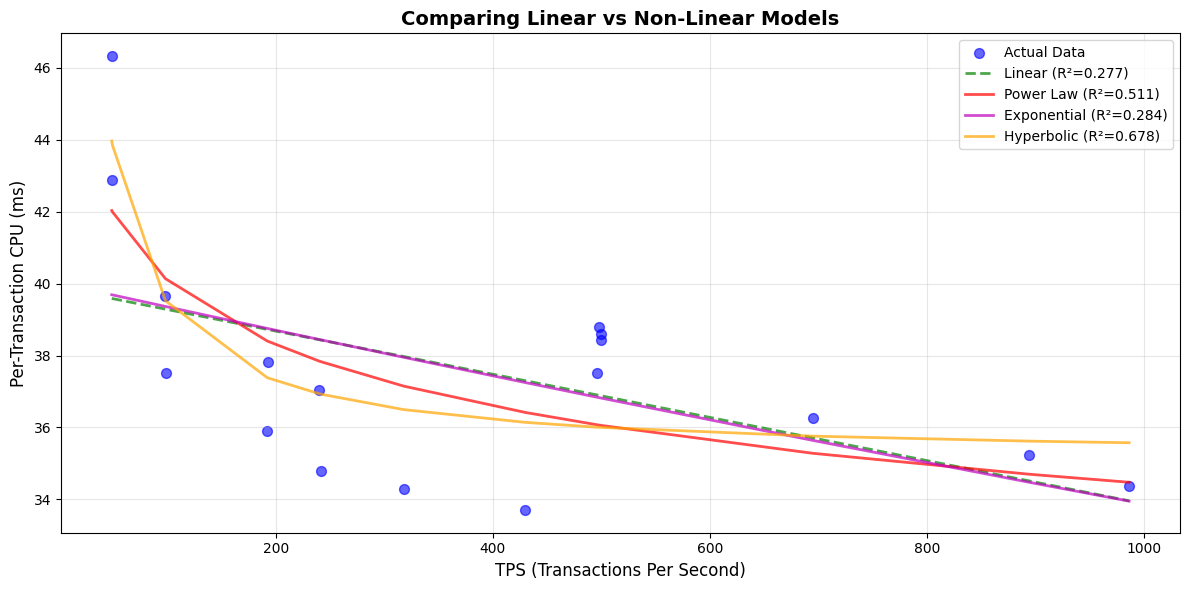


CONCLUSION:
The model with the highest R² value fits the data best.
For per-transaction metrics, a hyperbolic model often fits better because
CPU efficiency improves (per-txn cost decreases) as throughput increases.


In [20]:
# Visualize all models together
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Sort data for smooth curves
sort_idx = np.argsort(X_fit)
X_sorted = X_fit[sort_idx]
y_sorted = y_fit[sort_idx]

# Plot actual data
ax.scatter(X_fit, y_fit, alpha=0.6, s=50, label='Actual Data', color='blue')

# Plot linear model
ax.plot(X_sorted, intercept_1 + slope_1 * X_sorted, 'g--', linewidth=2, 
        label=f'Linear (R²={r_squared_1:.3f})', alpha=0.7)

# Plot non-linear models if they fit
try:
    y_power_sorted = power_law(X_sorted, *params_power)
    ax.plot(X_sorted, y_power_sorted, 'r-', linewidth=2, 
            label=f'Power Law (R²={r2_power:.3f})', alpha=0.7)
except:
    pass

try:
    y_exp_sorted = exponential(X_sorted, *params_exp)
    ax.plot(X_sorted, y_exp_sorted, 'm-', linewidth=2, 
            label=f'Exponential (R²={r2_exp:.3f})', alpha=0.7)
except:
    pass

try:
    y_hyp_sorted = hyperbolic(X_sorted, *params_hyp)
    ax.plot(X_sorted, y_hyp_sorted, 'orange', linewidth=2, 
            label=f'Hyperbolic (R²={r2_hyp:.3f})', alpha=0.7)
except:
    pass

ax.set_xlabel('TPS (Transactions Per Second)', fontsize=12)
ax.set_ylabel('Per-Transaction CPU (ms)', fontsize=12)
ax.set_title('Comparing Linear vs Non-Linear Models', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCONCLUSION:")
print("The model with the highest R² value fits the data best.")
print("For per-transaction metrics, a hyperbolic model often fits better because")
print("CPU efficiency improves (per-txn cost decreases) as throughput increases.")
